# Projeto de Ciência de Dados Airbnb Rio de Janeiro

## Contexto
<p>No Airbnb, qualquer indivíduo que possua um quarto ou propriedade de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode oferecê-lo para aluguel por diária.</p>
<p>Nesse sentido, a pessoa cria um perfil de host (quem disponibiliza a propriedade para aluguel) e elabora o anúncio do imóvel. Nele, o host descreve as características do local de maneira abrangente, auxiliando os locatários/viajantes na escolha do lugar ideal e tornando a propriedade mais atrativa.</p>
<p>O anúncio oferece diversas opções de personalização, que engloba desde a quantidade mínima de diárias, preço e número de quartos, até regras de cancelamento, taxa adicional para hóspedes extras, a necessidade de verificação de identidade do locatário, entre outras possibilidades.</p>

## Objetivo do Projeto
<p>Construir um modelo de previsão de preço que permita que um host possa saber quanto deve cobrar pela diária do seu imóvel ou que um locador possa saber se os preços estão atrativos (abaixo da média para imóveis com as mesma características) ou não para alugar.</p>

## Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import pathlib  # também existe a biblioteca glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
caminho_bases = pathlib.Path('./dataset')

meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

base_airbnb = pd.DataFrame()
for arquivo in caminho_bases.iterdir():
    if 'total' in arquivo.name:
        continue
    df_aux = pd.read_csv(arquivo)
    df_aux['arquivo'] = arquivo.name[:-4]
    df_aux['month'] = meses[arquivo.name[:3]]
    df_aux['year'] = int(arquivo.name[-8:-4])
    base_airbnb = pd.concat([base_airbnb, df_aux])


In [3]:
display(base_airbnb)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
34325,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
34326,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
34327,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


## Limpeza da Base de Dados
- Como a base de dados tem muitas colunas, o modelo possivelmente ficará bem lento.
- Uma análise rápida já permite perceber que várias colunas não são necessárias para treinar o modelo de previsão.
- Por isso, vamos excluir algumas colunas
- Tipos de colunas que vamos excluir:
    1. Colunas de identificações: IDs, links, informações não relevantes para o modelo
    2. Colunas repetidas ou muito parecidas (Ex: Data x Ano/Mês, Várias sobre a localização)
    3. Colunas de texto livre -> não rodaremos nenhuma análise de palavras
    4. Colunas em que todos ou quase todos os valores são iguais

- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa


In [4]:
# célula executada apenas uma vez
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

In [4]:
print(base_airbnb['experiences_offered'].value_counts())
print(base_airbnb['host_acceptance_rate'].value_counts())

experiences_offered
none    902210
Name: count, dtype: int64
host_acceptance_rate
100%    31697
0%       4744
50%      3781
99%      3320
67%      3140
        ...  
28%        22
15%        21
7%         20
51%        18
6%         11
Name: count, Length: 100, dtype: int64


In [5]:
# comparar colunas
print((base_airbnb['host_listings_count'] == base_airbnb['host_total_listings_count']).value_counts())

True     901750
False       460
Name: count, dtype: int64


In [6]:
print(base_airbnb['square_feet'].isnull().sum())  # muitos dados vazios

888162


Depois da análise qualitativa das colunas, levando com consideração os critérios explicados anteriormente. Ficamos com as seguintes 34 colunas:

In [7]:
primeiros_registros = pd.read_csv('primeiros_registros.csv', sep=';')
colunas = list(primeiros_registros.columns) 
base_airbnb = base_airbnb[colunas]
display(base_airbnb)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,month,year
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,4,2018
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,4,2018
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,4,2018
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,4,2018
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,4,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,9,2019
34325,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,9,2019
34326,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,9,2019
34327,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,9,2019


## Tratando de Valores Vazios (NaN)

Primeiramente, vamos analisar quais colunas tem valor NaN e quantidade de valores Nan que temos

A partir disso, temos três opções:
1. Exluir as colunas com muitos valores NaN
2. Excluir as linhas com valores NaN
3. Substituir o valor NaN com algum valor específico

In [8]:
# Analisar a quantidade de valores NaN em cada coluna
print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [9]:
# excluir as colunas com 300 mil ou mais valores NaN
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300_000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)


# excluir linhas com valores NaN
base_airbnb = base_airbnb.dropna()

# agora temos uma base de dados sem valores NaN
print(base_airbnb.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
month                       0
year                        0
dtype: int64


## Verificar Tipos de Dados em cada coluna

Isso é muito importante para o modelo de previsão. <br>
O modelo de previsão age de maneiras diferentes para cada tipo de dado, então é importante que o mês esteja sendo entendido, de fato, como um número, que o ano seja um número e assim por diante.

In [10]:
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
month                         int64
year                          int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

- Com essa análise, podemos ver que as colunas "price" e "extra_people" estão sendo reconhecidos como objetos (ou string), quando deveriam ser tratadas como float.
- Isso se deve a 2 fatos:
    1. Tem o símbolo "$" em cada célula dessas colunas
    2. O separador de milhar é uma vírgula (2,000 -> dois mil), o que não funciona para linguagem de programação
- Então precisamos tratar mudar o tipo de dado.

In [11]:
# price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

# extra_people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

# Verificando os tipos
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
month                         int64
year                          int64
dtype: object


## Análise Exploratória e Tratar Outliers
- Vamos basicamente olhar feature por feature para:
    1. Examinar a correlação entre as features e decidir se manteremos todas que temos
    2. Excluir outliers -> utilizaremos as regras de <a href="https://statplace.com.br/blog/como-interpretar-um-boxplot/#:~:text=Sendo%20assim%2C%20os%20limites%20inferior,(Terceiro%20Quartil%20%E2%80%93%20Primeiro%20Quartil)">Limite Superior e Inferior</a> para construção de um boxplot em Estatística. 
        - LI = Q1 - 1.5 * (Q3 - Q1)
        - LS = Q4 + 1.5 * (Q3 + Q1)
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e devemos excluir

- Vamos começas pelas colunas de valores contínuos (como "price" e "extra_people")
- Depois, vamos analisar as colunas com valores discretos (como "accomodates", "bedroom", ...)
- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido termos ou não

**CUIDADO**: não excluir os outliers de imediato, os analisaremos primeiramente. Se não tem motivo claro para remover o outlier, talvez não seja necessário e pode até ser prejudicial para a generalização. -> é claro que poderia testar com o outlier e sem o outlier para ver qual o melhor, mas fazer isso para cada feature é bem trabalhoso e nada eficiente.

Exemplo de análise: se o objetivo é ajudar a precificar um imóvel que está querendo disponibilizar, excluir outliers em "host_listings_count" pode fazer sentido. Agora, para uma empresa com uma série de propriedades que quer comparar com outras empresas do tipo, talvez excluir outliers pode não fazer sentido. -> Pensar sempre no nosso *objetivo*!

<Axes: >

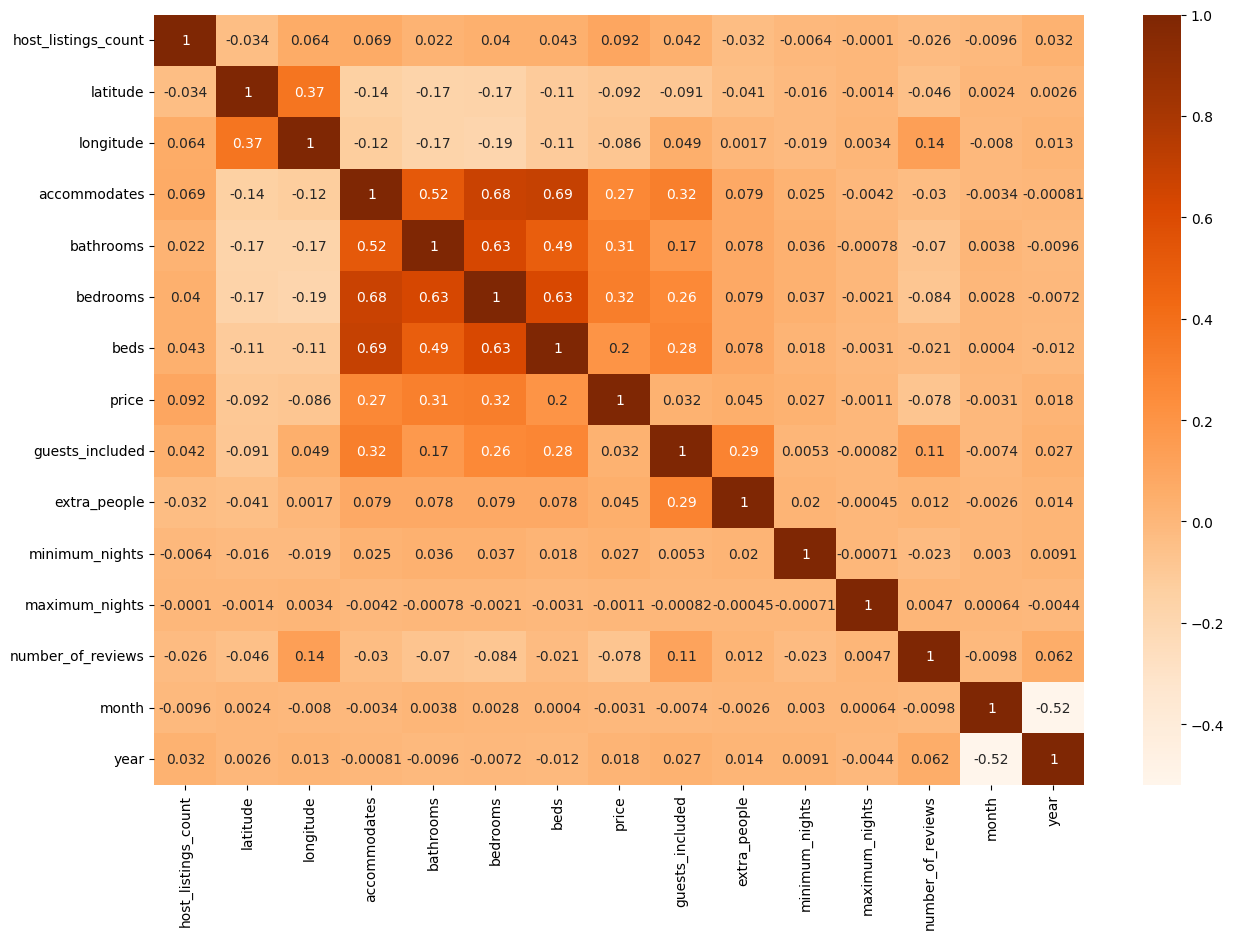

In [12]:
# Correlação utilizando um mapa de calor para melhor visualização
plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.corr(numeric_only=True), annot=True, cmap="Oranges")

### Definição de funções para Análise Explorativa

Vamos definir algumas funções para ajudar na análise de outliers das colunas:
- limites: calcula os limites inferior e superior
- boxplot: plota um diagrama de caixa (boxplot) dos dados passados -> boxplot nos mostra onde está a maioria dos nosso dados
- histograma: plota um gráfico de histograma dos dados passados -> como aquela série de dados se comporta  

In [37]:
# função para calcular limites inferior e superior
def limites(coluna):
    '''
    coluna: é uma coluna de um DataFrame do pandas
    '''
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3-q1
    li = q1 - 1.5*amplitude
    ls = q3 + 1.5*amplitude

    return (li, ls)


# função para excluir outliers
def excluir_outliers(df, nome_coluna):
    qtd_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtd_linhas - df.shape[0]
    return df, linhas_removidas


# função para plotar o boxplot
def boxplot(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)  # ax1 é o eixo do primeiro gráfico, ax2 do segundo gráfico
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)


# função para plotar histograma
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    b = (coluna.value_counts()).shape[0]
    sns.histplot(coluna, bins=b//10, kde=True, kde_kws=dict(cut=3), stat='density', alpha=.4, edgecolor=(1, 1, 1, .4))


# função de gráfico de barras
def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts(), color='salmon')
    ax.set_xlim(limites(coluna))

### Coluna price

Tirar ou não os outliers? <br>
Vamos sim tirar outliers de price nesse projeto, uma vez que nosso objetivo é prever o preço de futuras diárias para imóveis comuns. Esses lugares que estão com preços muito maiores, provavelmente, são lugares altíssimo luxo.

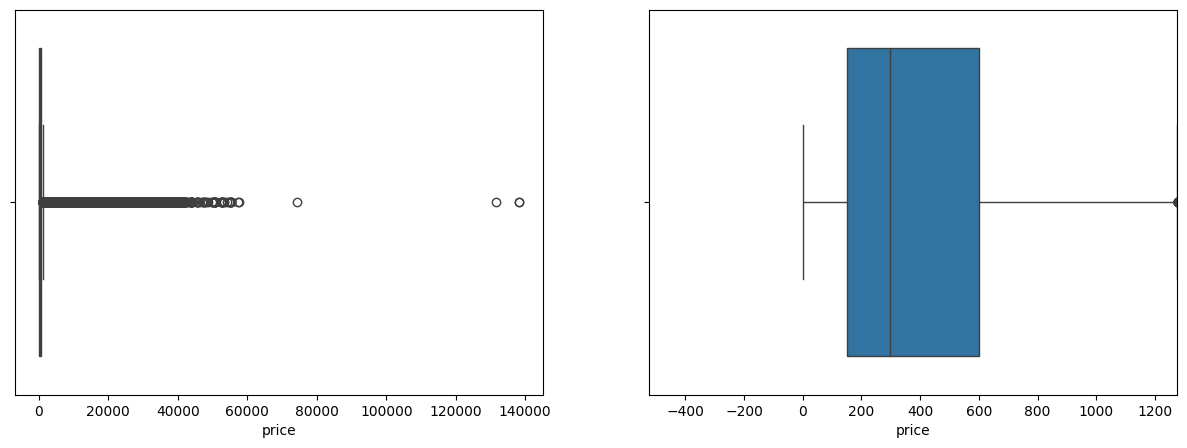

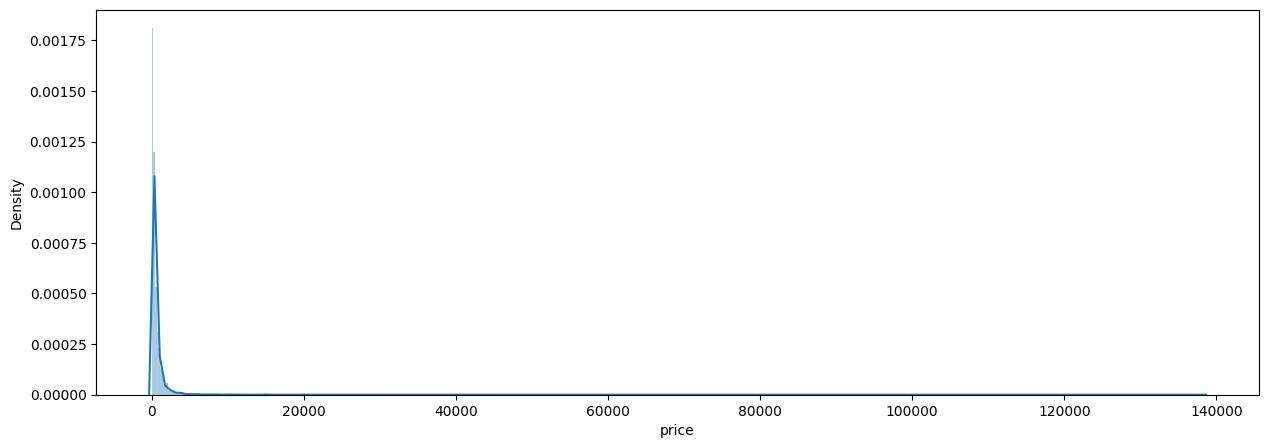

In [14]:
boxplot(base_airbnb['price'])
histograma(base_airbnb['price'])

In [15]:
base_airbnb, linhas_excluidas = excluir_outliers(base_airbnb, 'price')

print(f"{linhas_excluidas} linhas removidas")

87282 linhas removidas


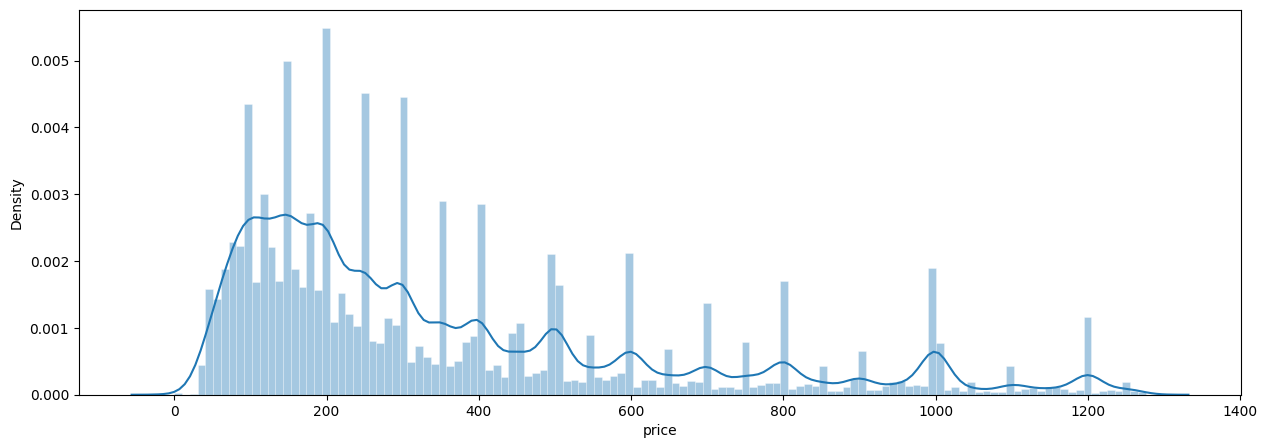

In [16]:
histograma(base_airbnb['price'])

### Coluna extra_people

Tirar ou não tirar outliers? <br>
Nesse projeto vamos excluir os outliers do extra_people. Podemos testar no final com os outliers de extra people.

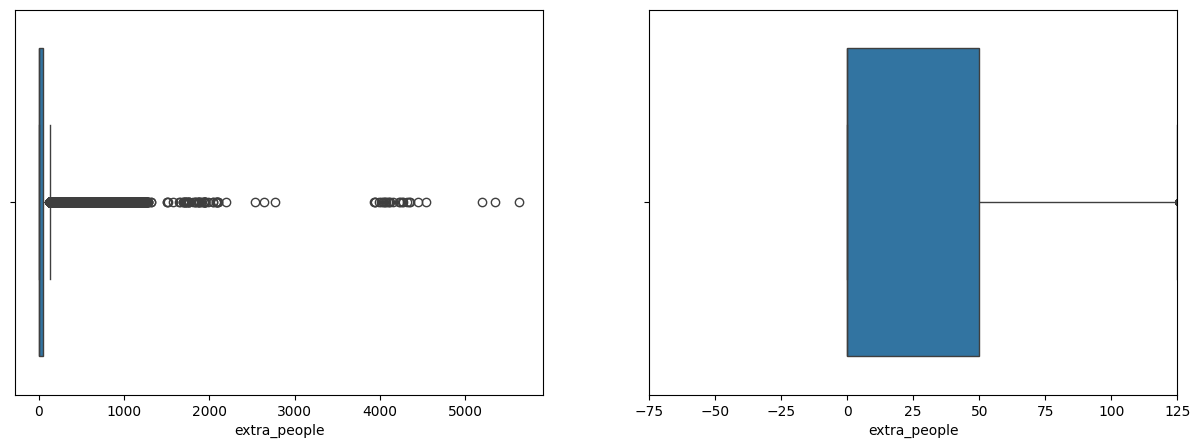

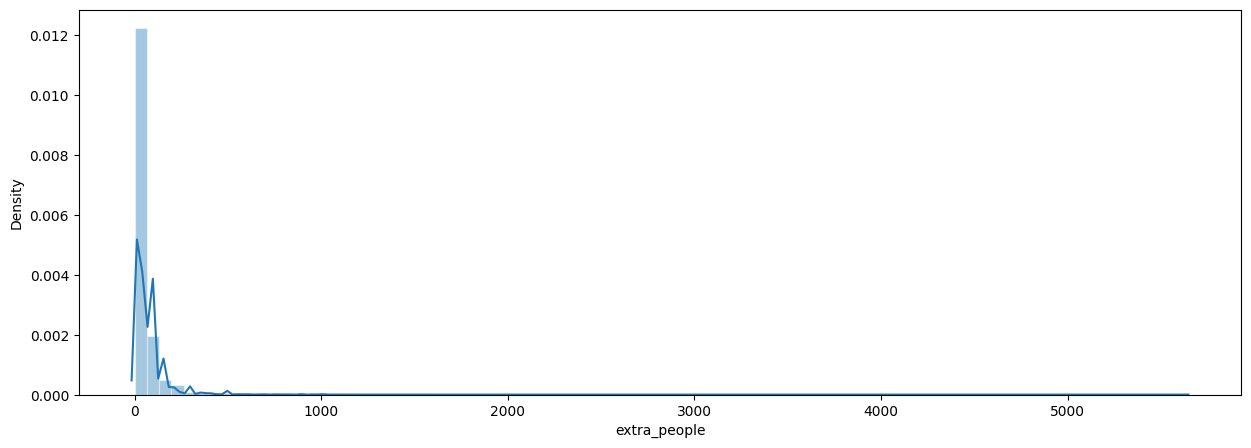

In [17]:
boxplot(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [18]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print(f"{linhas_removidas} linhas removidas")

59194 linhas removidas


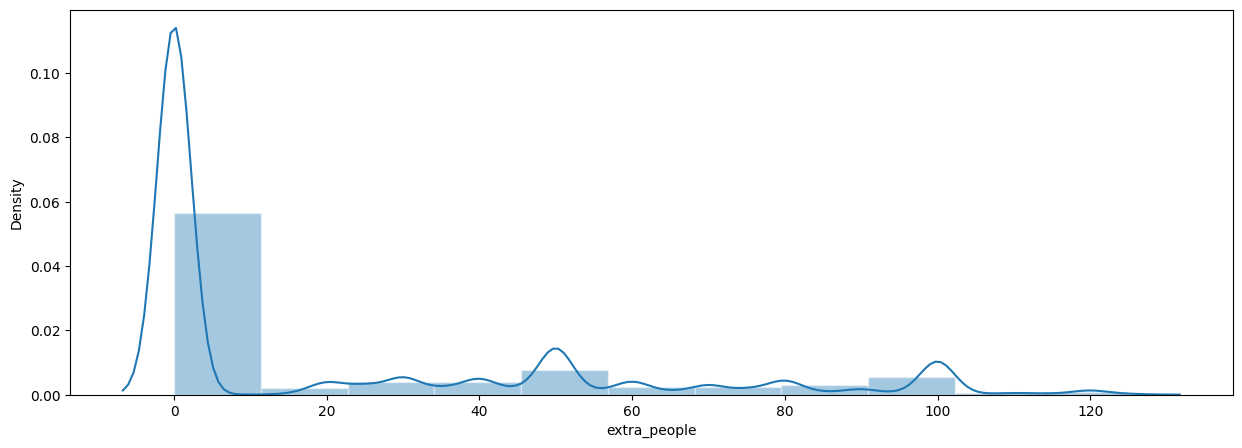

In [23]:
histograma(base_airbnb['extra_people'])

### Coluna host_listings_count

host_listings_count -> quantos imóveis a pessoa tem disponível no airbnb

Podemos excluir os outliers, porque hosts com mais de 6 imóveis no airbnb nãp está no público alvo do objetivo do projeto (talvez seja imobiliárias ou profissionais que gereciam isso)

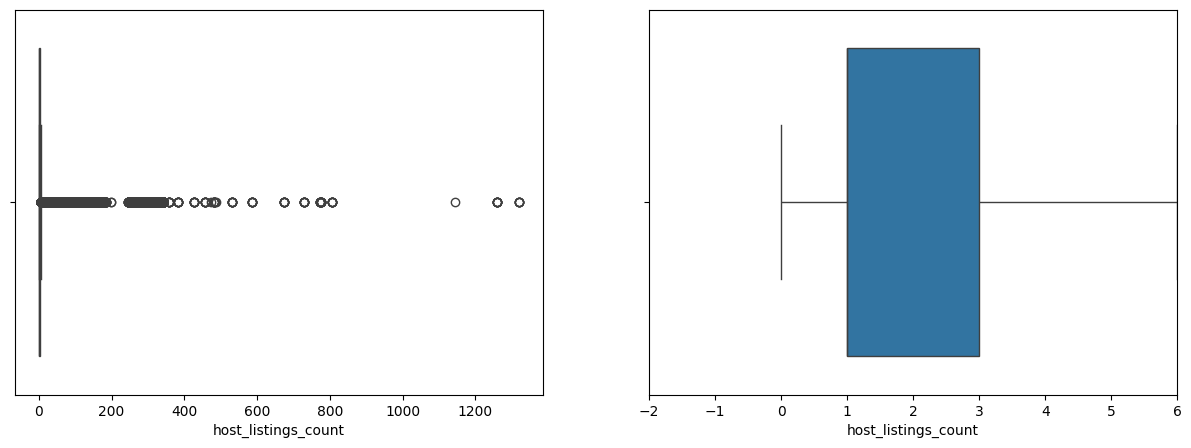

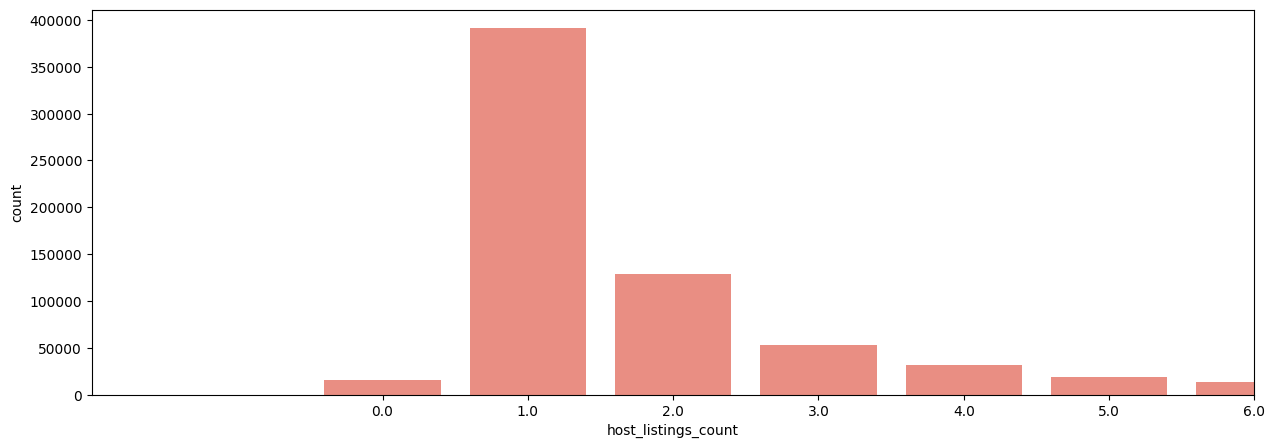

In [38]:
boxplot(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

In [39]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print(f"{linhas_removidas} linhas removidas")

97723 linhas removidas
